NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


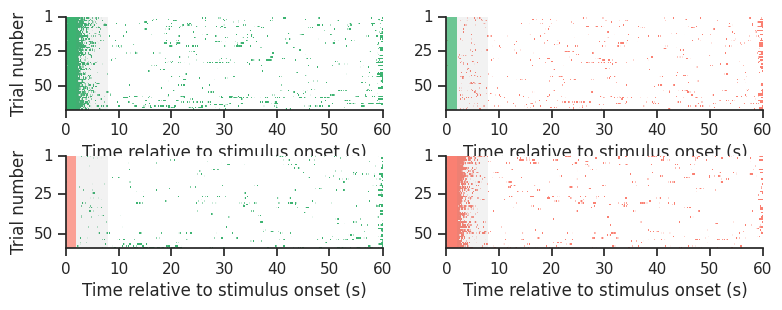

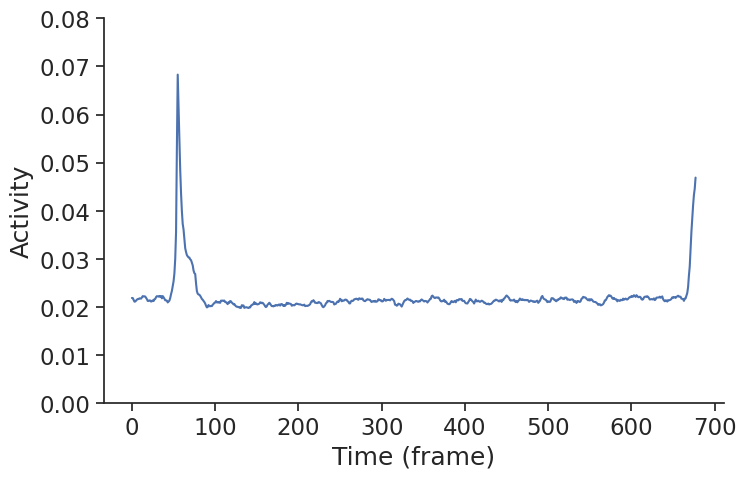

NN11 210627
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


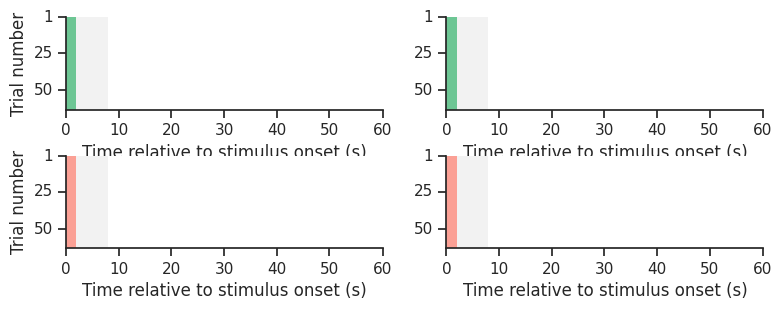

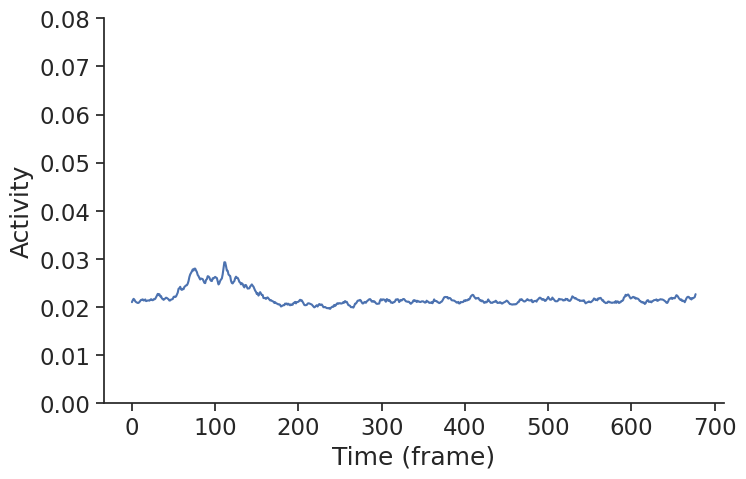

NN11 210628
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


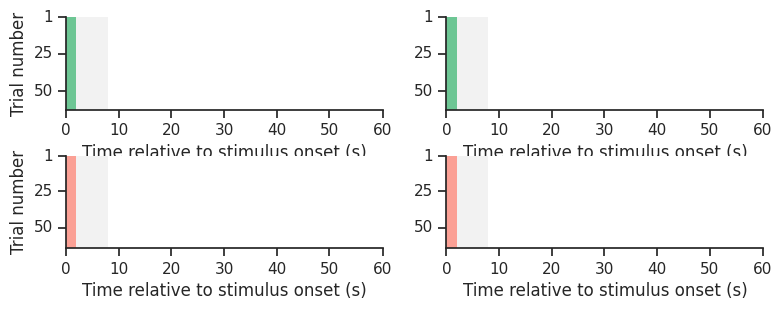

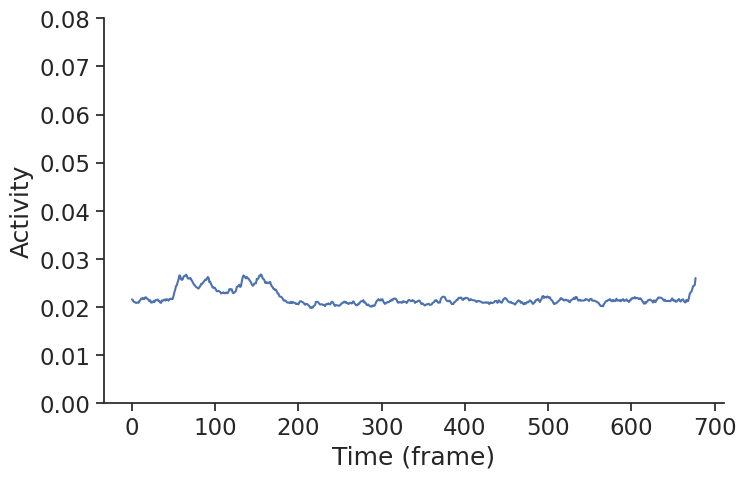

NN11 210629
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


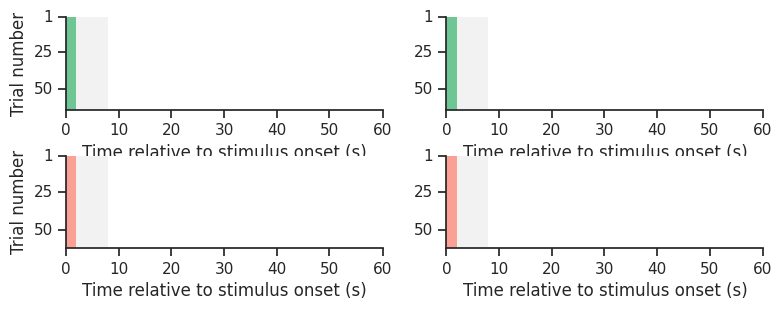

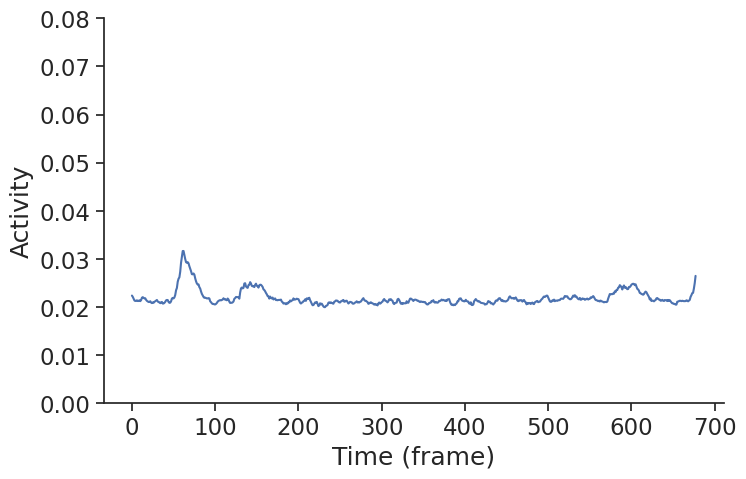

NN11 210630
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


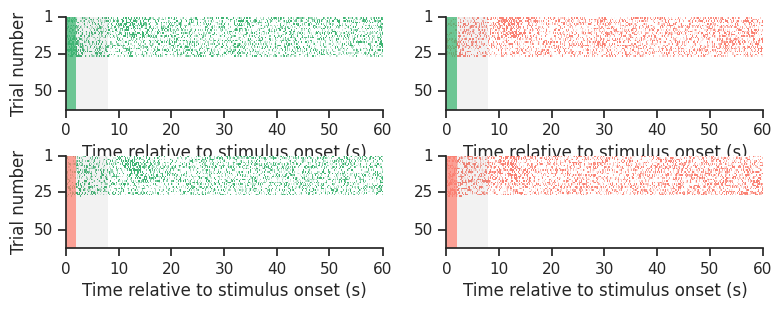

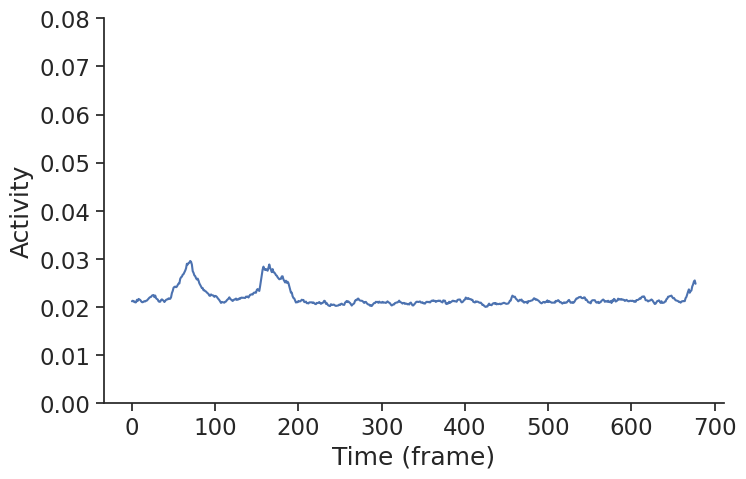

NN11 210701
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


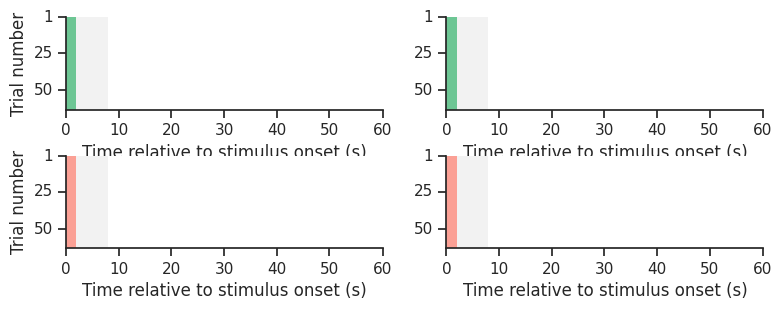

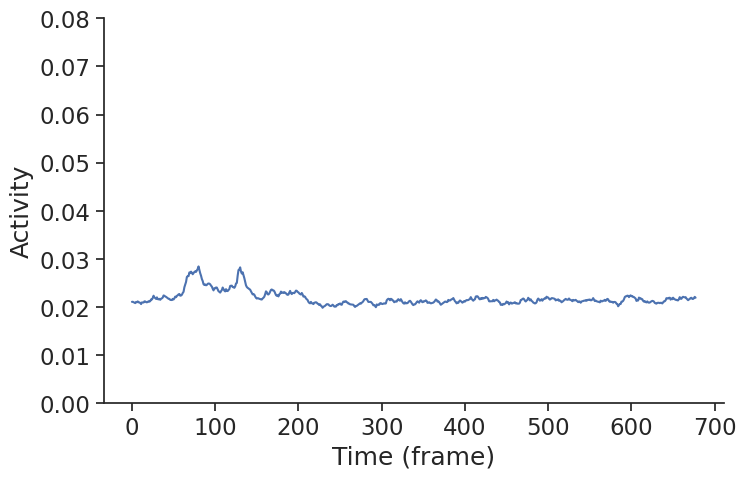

NN11 210704
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


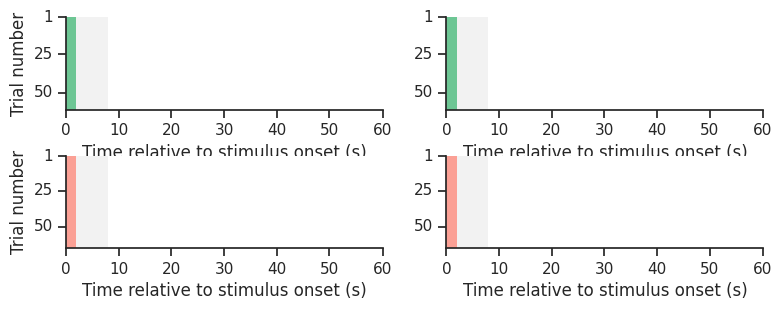

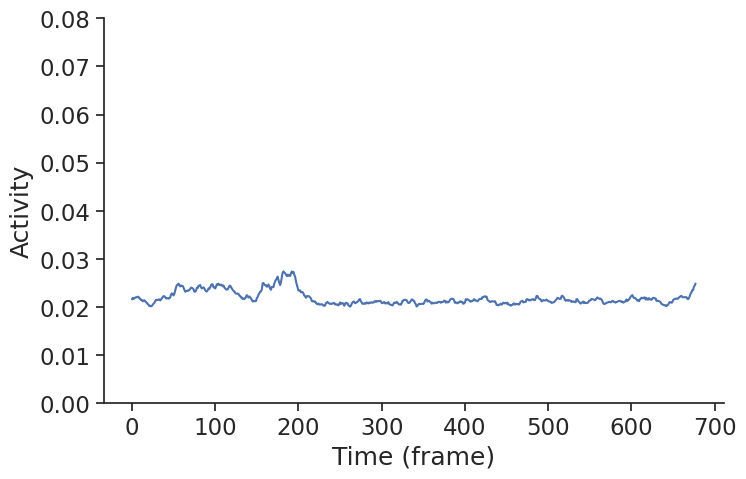

NN11 210706
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


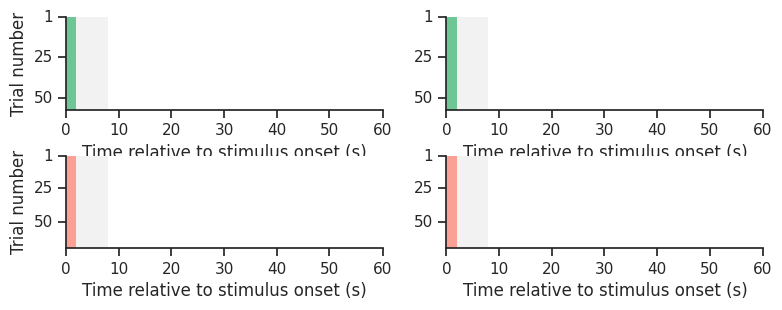

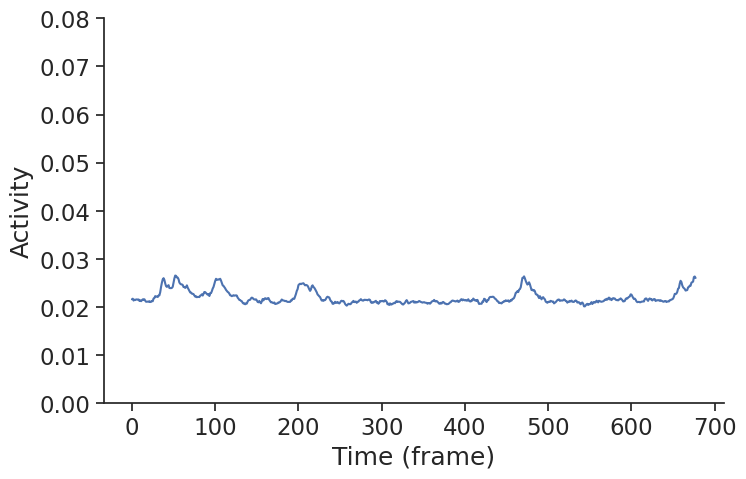

In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)

# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] #, 'NN9', 'NN11', 'NN13', 'NN16', 'NN17', 'NN23', 'NN28']
dates_per_mouse = {'NN11': ['210626','210627', '210628', '210629', '210630', '210701', '210704', '210706']}
#, '210314', '210316', '210318', '210320', '210321', '210327', '210329', '210330'],
# dates_per_mouse = {'NN8': ['210318', '210320', '210321', '210327', '210329', '210330'],
                    # 'NN9': ['210428', '210429', '210501', '210502', '210503', '210505', '210506', '210507', '210509', '210510', '210511', '210512', '210513', '210514'],
                    # 'NN11': ['210626', '210627', '210628', '210629', '210630', '210701', '210703', '210704', '210705', '210706'],
                    # 'NN13': ['210811', '210812', '210813', '210814', '210815', '210816', '210817', '210818'],
                    # 'NN16': ['211014', '211015', '211016', '211017', '211018', '211019', '211020', '211021', '211022'],
                    # 'NN17': ['211025', '211026', '211028', '211029', '211030', '211031', '211101'],
                    # 'NN23': ['220416', '220417', '220418', '220419', '220420', '220421', '220422', '220423', '220424'],
                    # 'NN28': ['230210', '230211', '230212', '230214', '230216', '230217']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        y_pred_log = classify.log_regression(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')

        #get y_pred_binned.npy to analyze across days
        plot.reactivation_rate(y_pred, behavior, paths, day=day_idx)

        #plot all reactivation bias over time
        plot.reactivation_bias(y_pred, behavior, paths, day=day_idx, days= days)

        #plot trial reactivation
        plot.rate_within_trial(y_pred, behavior, paths, day=day_idx, days=days)

        #plot bias within trial reactivation
        plot.bias_within_trial(y_pred, behavior, paths, day= day_idx, days= days)

        #get iti activity across trials
        plot.iti_activity_across_trials(norm_deconvolved, y_pred, idx, behavior, paths, day=day_idx)

        #plot iti activity within trials
        plot.iti_activity_within_trial(norm_deconvolved, idx, behavior, paths, day=day_idx, days=days)

        #plot trial evoked reactivation
        plot.trial_reactivations(y_pred, behavior, paths)

        #plot trial history modulation
        plot.trial_history(norm_deconvolved, idx, y_pred, behavior, paths, num_prev=10, day=day_idx, days=days)
        
        #get activity.npy to analyze across days
        plot.activity_across_trials(norm_deconvolved, behavior, y_pred, idx, paths, day=day_idx, days=days)

        #plot cs activity
        plot.activity_control(norm_deconvolved, behavior, paths, day=day_idx, days=days)

        #make correlation similarity and acitivty accross trials
        plot.activity_across_trials_grouped(norm_deconvolved, behavior, idx, paths, day=day_idx, days=days)

        #omit and same as one above
        plot.activity_across_trials_grouped_omit(norm_deconvolved, behavior, idx, paths, day=day_idx, days=days)

        #get correlaction and activity and reactivation per trial
        plot.activity_across_trials_grouped_separate(norm_deconvolved, behavior, idx, paths, day=day_idx, days=days)
                
        #length of reactivation pre vs post cues
        plot.reactivation_duration

        #mean activity during cue and reactivation of top vs bottom cue cues
        plot.reactivation_top_bottom_activity(norm_deconvolved, idx, y_pred, behavior, both_poscells, paths, day=day_idx, days= days)

        #reactivation cue vector
        #plot.reactivation_cue_vector(norm_deconvolved, idx, y_pred, behavior, paths, day=day_idx, days=days)



    


In [ ]:
import plot_across_days
plot_across_days.activity_reactivation(paths)

In [ ]:
#empty plots because stacking of data across days?
#or overwriting or something, perhaps data is combined?


In [1]:
import numpy as np
cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Convert normalized deconvolved data to a numpy array and filter based on index.
activity = norm_moving_deconvolved_filtered
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


NameError: name 'norm_moving_deconvolved_filtered' is not defined

In [ ]:

# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] == 0 and reactivation_cs_2[i + 1] == 0:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


[0.35900527 0.99705347 0.32344386 ... 0.3125269  0.78274796 0.67952962] [0.33019743 0.00294653 0.59559303 ... 0.35116941 0.20286384 0.3172606 ]
106665 106665
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [16]:

# Normalize the reactivation mean activities.
# mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
# mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)

In [17]:
Nr = 30
topn = 0.05

theta_tl = np.zeros((Nr,))
theta_bp = np.zeros((Nr,))

dist_tl = np.zeros((Nr,))
dist_bp = np.zeros((Nr,))

for i in range(0, Nr):
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]

    rho_tl = mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)]
    rho_bp = mean_activity_cs_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)]
    
    # theta_tl[i] = np.arccos(cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], rho_tl))
    # theta_bp[i] = np.arccos(cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], rho_bp))

    theta_tl[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], rho_tl)
    theta_bp[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], rho_bp)

    measure_tl = 1 - np.square(theta_tl)
    measure_bp = 1 - np.square(theta_bp)

    # Distances
    # dist_tl = np.sqrt(np.sum(np.square(r_2[:Nr,:] - late_2), axis=1))
    # dist_bp = np.sqrt(np.sum(np.square(r_2[:Nr,:] - cs_2[:Nr,:]), axis=1))
    dist_tl[i] = np.sqrt(np.sum(np.square(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)] - rho_tl)))
    dist_bp[i] = np.sqrt(np.sum(np.square(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)] - rho_bp)))

In [18]:
dist_tl, dist_bp

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.68469618, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.02778414, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]))

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise cosine similarity of reactivation patterns
similarity_matrix_cs_1 = cosine_similarity(mean_activity_r_1)
similarity_matrix_cs_2 = cosine_similarity(mean_activity_r_2)

plt.figure(figsize=(10, 8))
plt.title("Pairwise Cosine Similarity of Reactivation Patterns (CS_1)")
plt.imshow(similarity_matrix_cs_1, cmap="viridis", aspect="auto")
plt.colorbar(label="Cosine Similarity")
plt.xlabel("Reactivation")
plt.ylabel("Reactivation")
plt.show()

plt.figure(figsize=(10, 8))
plt.title("Pairwise Cosine Similarity of Reactivation Patterns (CS_2)")
plt.imshow(similarity_matrix_cs_2, cmap="viridis", aspect="auto")
plt.colorbar(label="Cosine Similarity")
plt.xlabel("Reactivation")
plt.ylabel("Reactivation")
plt.show()

Current working directory: /home/lbeumer/reactivation/Reactivation/normal


In [ ]:

# Heatmap for CS_1 Reactivations
plt.figure(figsize=(12, 6))
sns.heatmap(mean_activity_r_1, cmap="viridis", cbar=True)
plt.title("CS 1 reactivation activity per reactivation event)")
plt.xlabel("Frames")
plt.ylabel("Neurons")
plt.show()

# Heatmap for CS_2 Reactivations
plt.figure(figsize=(12, 6))
sns.heatmap(mean_activity_r_2, cmap="viridis", cbar=True)
plt.title("CS 2 reactivation activity per reactivation event")
plt.xlabel("Frames")
plt.ylabel("Neurons")
plt.show()


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reactivations_pca1 = pca.fit_transform(mean_activity_r_1.T)

# Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(reactivations_pca1[:, 0], reactivations_pca1[:, 1], alpha=0.7)
plt.title("PCA of Reactivation Patterns CS1")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

print(pca.explained_variance_ratio_)

reactivations_pca2 = pca.fit_transform(mean_activity_r_2.T)

# Plot the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(reactivations_pca2[:, 0], reactivations_pca2[:, 1], alpha=0.7)
plt.title("PCA of Reactivation Patterns CS2 ")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

print(pca.explained_variance_ratio_)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity
similarity_matrix1 = cosine_similarity(mean_activity_r_1.T)

# Plot similarity matrix
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix1, cmap="viridis", cbar=True)
plt.title("Cosine Similarity Between CS 1 Reactivation")
plt.xlabel("Neurons")
plt.ylabel("Neurons")
plt.show()

# Compute cosine similarity
similarity_matrix2 = cosine_similarity(mean_activity_r_2.T)

# Plot similarity matrix
plt.figure(figsize=(12, 8))
sns.heatmap(similarity_matrix2, cmap="viridis", cbar=True)
plt.title("Cosine Similarity Between CS 2Reactivation")
plt.xlabel("Neurons")
plt.ylabel("Neurons")
plt.show()



In [19]:
from scipy.stats import norm

plt.figure(figsize=(20, 10))

bin_size = 0.04

# plt.gca().invert_yaxis()  # Flip the y-axis
plt.hist(measure_tl, bins=np.arange(min(measure_tl), max(measure_tl) + bin_size, bin_size), label="tl", color='#0f8141', alpha=0.5, edgecolor='none')
plt.hist(measure_bp, bins=np.arange(min(measure_bp), max(measure_bp) + bin_size, bin_size), label="bp", color='#3c54a4', alpha=0.5, edgecolor='none')
# plt.axvline(y=0, color='#f06ca8', linestyle='-')

# Fit normal distribution to theta_tl
mu_tl, std_tl = norm.fit(measure_tl)
x_tl = np.linspace(0, 1, 500)
y_tl = norm.pdf(x_tl, mu_tl, std_tl)
plt.plot(x_tl, y_tl, label='tl normal distribution', alpha=1, color='#0f8141')
plt.axvline(x=mu_tl, color='#0f8141', linestyle='--')

# Fit normal distribution to theta_bp
mu_bp, std_bp = norm.fit(measure_bp)
x_bp = np.linspace(0, 1, 500)
y_bp = norm.pdf(x_bp, mu_bp, std_bp)
plt.plot(x_bp, y_bp, label='bp normal distribution', alpha=1, color='#3c54a4')
plt.axvline(x=mu_bp, color='#3c54a4', linestyle='--')

plt.xlim(0, 1)
plt.legend()
plt.savefig(f'NN11/GRAPHS/210706/distribution_cortex_06.png', format='png', bbox_inches="tight")
plt.show()

ValueError: arange: cannot compute length

<Figure size 2000x1000 with 0 Axes>

In [9]:
from scipy.stats import ttest_ind, wilcoxon

t_tlbp, p_tlbp = ttest_ind(measure_tl, measure_bp, equal_var=False)

t_tlbp, p_tlbp

(-4.585045042895215, 7.726399529771234e-05)

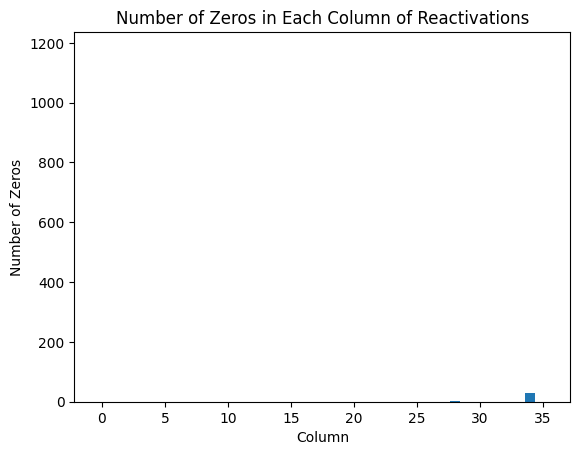

<Figure size 640x480 with 0 Axes>

In [10]:
# Count the number of zeros in each column
zeros_per_column = np.sum(mean_activity_r_1 == 0, axis=1)

# Create a bar plot
plt.bar(range(mean_activity_r_1.shape[0]), zeros_per_column)
plt.ylim([0, mean_activity_r_1.shape[1]])
plt.xlabel('Column')
plt.ylabel('Number of Zeros')
plt.title('Number of Zeros in Each Column of Reactivations')
plt.show()
plt.savefig(f'NN11/GRAPHS/210706/zeros_06.png', format='png', bbox_inches="tight")


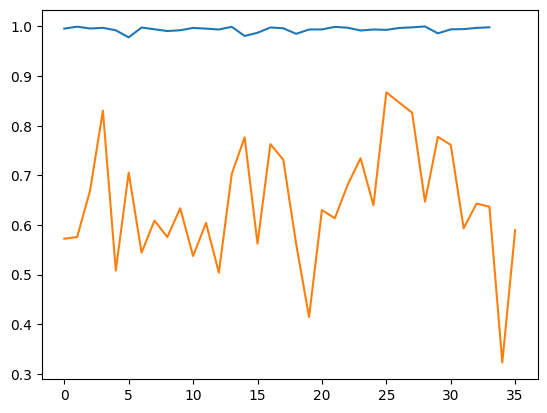

In [11]:
plt.plot(sim_r_2)
plt.plot(sim_r_1_random)
# plt.plot(mean_activity_r_1[0])
plt.savefig(f'NN11/GRAPHS/210706/sim_r2_r1rand_06.png', format='png', bbox_inches="tight")


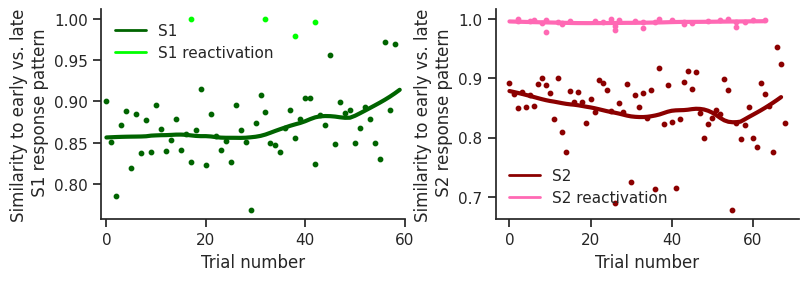

In [12]:
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from plot import Loess

sns.set(font_scale=1)
sns.set_style("whitegrid", {'axes.grid': False})
sns.set_style("ticks")
plt.figure(figsize=(9, 6))
plt.subplots_adjust(wspace=.3)
m_size = 10
plt.subplot(2, 2, 1)
# plt.ylim(-2.1, .1)
# plt.gca().invert_yaxis()
plt.scatter(x=list(range(0, len(sim_cs_1))), y=sim_cs_1, color='darkgreen', s=m_size)
plt.scatter(x=trial_r_1, y=sim_r_1, color='lime', s=m_size)
plt.xlim(-1, 60)
# plt.xticks([0, 19, 39, 59], ['1', '20', '40', '60'])
plt.ylabel('Similarity to early vs. late\n S1 response pattern')
plt.xlabel('Trial number')
label_1 = mlines.Line2D([], [], color='darkgreen', linewidth=2, label='S1')
label_2 = mlines.Line2D([], [], color='lime', linewidth=2, label='S1 reactivation')
# label_3 = mlines.Line2D([], [], color='k', linewidth=2, label='S1 reactivation baseline')
plt.legend(handles=[label_1, label_2], frameon=False)
plt.subplot(2, 2, 2)
# plt.ylim(-2.1, .1)
# plt.gca().invert_yaxis()
plt.scatter(x=list(range(0, len(sim_cs_2))), y=sim_cs_2, color='darkred', s=m_size)
plt.scatter(x=trial_r_2, y=sim_r_2, color='hotpink', s=m_size)
# plt.xlim(-1, 60)
# plt.xticks([0, 19, 39, 59], ['1', '20', '40', '60'])
plt.ylabel('Similarity to early vs. late\n S2 response pattern')
plt.xlabel('Trial number')
label_1 = mlines.Line2D([], [], color='darkred', linewidth=2, label='S2')
label_2 = mlines.Line2D([], [], color='hotpink', linewidth=2, label='S2 reactivation')
# label_3 = mlines.Line2D([], [], color='k', linewidth=2, label='S2 reactivation baseline')
plt.legend(handles=[label_1, label_2], frameon=False)
sns.despine()

plt.subplot(2, 2, 1)
xx = list(range(0, len(sim_cs_1)))
yy = sim_cs_1
loess = Loess(xx, yy)
x_plot_s1 = []
y_plot_s1 = []
for x in range(0, 60):
    y = loess.estimate(x, window=np.max([20, int(len(sim_cs_1)/3)]), use_matrix=False, degree=1)
    x_plot_s1.append(x)
    y_plot_s1.append(y)
plt.plot(x_plot_s1, y_plot_s1, c='darkgreen', linewidth=3)
xx = trial_r_1
yy = sim_r_1
loess = Loess(xx, yy)
x_plot_s1r = []
y_plot_s1r = []
for x in range(0, 60):
    y = loess.estimate(x, window=np.min([np.max([20, int(len(sim_r_1)/3)]), len(sim_r_1)]), use_matrix=False, degree=1)
    x_plot_s1r.append(x)
    y_plot_s1r.append(y)
if np.max(trial_r_1) < len(y_plot_s1r):
    for i in range(np.max(trial_r_1) + 1, len(y_plot_s1r)):
        y_plot_s1r[i] = np.nan
plt.plot(x_plot_s1r, y_plot_s1r, c='lime', linewidth=3)
plt.subplot(2, 2, 2)
xx = list(range(0, len(sim_cs_2)))
yy = sim_cs_2
loess = Loess(xx, yy)
x_plot_s2 = []
y_plot_s2 = []
for x in range(0, 68):
    y = loess.estimate(x, window=np.max([20, int(len(sim_cs_2)/3)]), use_matrix=False, degree=1)
    x_plot_s2.append(x)
    y_plot_s2.append(y)
plt.plot(x_plot_s2, y_plot_s2, c='darkred', linewidth=3)
xx = trial_r_2
yy = sim_r_2
loess = Loess(xx, yy)
x_plot_s2r = []
y_plot_s2r = []
for x in range(0, 68):
    y = loess.estimate(x, window=np.min([np.max([20, int(len(sim_r_2)/3)]), len(sim_r_2)]), use_matrix=False, degree=1)
    x_plot_s2r.append(x)
    y_plot_s2r.append(y)
if np.max(trial_r_2) < len(y_plot_s2r):
    for i in range(np.max(trial_r_2) + 1, len(y_plot_s2r)):
        y_plot_s2r[i] = np.nan
plt.plot(x_plot_s2r, y_plot_s2r, c='hotpink', linewidth=3)
plt.savefig(f'NN11/GRAPHS/210706/correct_plt_06.png', format='png', bbox_inches="tight")


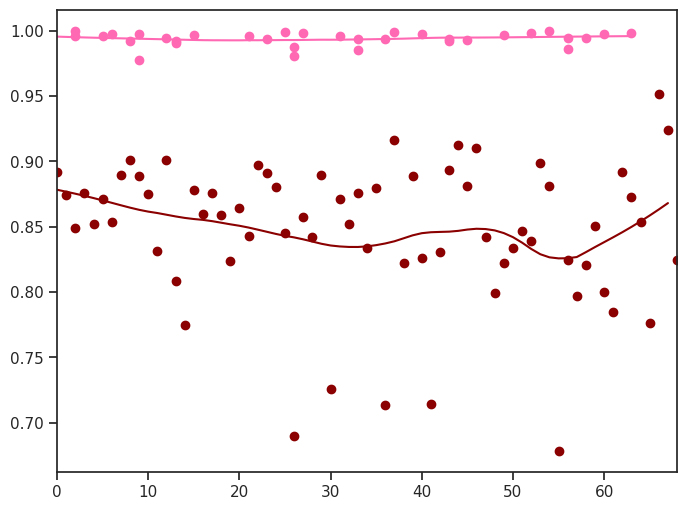

In [13]:
fig, _ = plt.subplots(figsize=(8,6))
# plt.ylim(-2.1, .1)
# plt.gca().invert_yaxis()
plt.scatter(x=list(range(0, len(sim_cs_2))), y=sim_cs_2, color='darkred', label='stim')
plt.scatter(x=trial_r_2, y=sim_r_2, color='hotpink', label='react')
plt.xlim(0, 68)
# plt.xticks([0, 19, 39, 59], ['1', '20', '40', '60'])
# plt.ylabel('Similarity to early vs. late\n S2 response pattern')
# plt.xlabel('Trial number')
# label_1 = mlines.Line2D([], [], color='darkred', linewidth=2, label='S2')
# label_2 = mlines.Line2D([], [], color='hotpink', linewidth=2, label='S2 reactivation')
# label_3 = mlines.Line2D([], [], color='k', linewidth=2, label='S2 reactivation baseline')
# plt.legend(handles=[label_1, label_2], frameon=False)
# sns.despine()

xx = list(range(0, len(sim_cs_2)))
yy = sim_cs_2
loess = Loess(xx, yy)
x_plot_s2 = []
y_plot_s2 = []
for x in range(0, 68):
    y = loess.estimate(x, window=np.max([20, int(len(sim_cs_2)/3)]), use_matrix=False, degree=1)
    x_plot_s2.append(x)
    y_plot_s2.append(y)
plt.plot(x_plot_s2, y_plot_s2, c='darkred', label='stim')
xx = trial_r_2
yy = sim_r_2
loess = Loess(xx, yy)
x_plot_s2r = []
y_plot_s2r = []
for x in range(0, 68):
    y = loess.estimate(x, window=np.min([np.max([20, int(len(sim_r_2)/3)]), len(sim_r_2)]), use_matrix=False, degree=1)
    x_plot_s2r.append(x)
    y_plot_s2r.append(y)
if np.max(trial_r_2) < len(y_plot_s2r):
    for i in range(np.max(trial_r_2) + 1, len(y_plot_s2r)):
        y_plot_s2r[i] = np.nan
plt.plot(x_plot_s2r, y_plot_s2r, c='hotpink')

plt.savefig(f'NN11/GRAPHS/210706/correct_pink_06.png', format='png', bbox_inches="tight")


## PCA

In [14]:
# early_1 = mean_activity_cs_1_mean[0][top_n_percent_indices_1]
# late_1 = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# early_2 = mean_activity_cs_2_mean[0][top_n_percent_indices_2]
# late_2 = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

# cs_1 = mean_activity_cstopn_1
# cs_2 = mean_activity_cstopn_2

# r_1 = mean_activity_rtopn_1
# r_2 = mean_activity_rtopn_2
topn = 0.1

top_n_percent_indices_r1 = np.argsort(np.mean(mean_activity_r_1,axis=0))[-int(mean_activity_r_1.shape[1] * topn):]
top_n_percent_indices_cs1 = np.argsort(np.mean(mean_activity_cs_1,axis=0))[-int(mean_activity_cs_1.shape[1] * topn):]
topn_indices_1 = np.intersect1d(top_n_percent_indices_r1, top_n_percent_indices_cs1)

top_n_percent_indices_r2 = np.argsort(np.mean(mean_activity_r_2,axis=0))[-int(mean_activity_r_2.shape[1] * topn):]
top_n_percent_indices_cs2 = np.argsort(np.mean(mean_activity_cs_2,axis=0))[-int(mean_activity_cs_2.shape[1] * topn):]
topn_indices_2 = np.intersect1d(top_n_percent_indices_r2, top_n_percent_indices_cs2)

early_1 = mean_activity_cs_1_mean[0][topn_indices_1]
late_1 = mean_activity_cs_1_mean[1][topn_indices_1]
early_2 = mean_activity_cs_2_mean[0][topn_indices_2]
late_2 = mean_activity_cs_2_mean[1][topn_indices_2]

cs_1 = mean_activity_cs_1[:,topn_indices_1]
r_1 = mean_activity_r_1[:,topn_indices_1]
cs_2 = mean_activity_cs_2[:,topn_indices_2]
r_2 = mean_activity_r_2[:,topn_indices_2]

print(early_1.shape, late_1.shape, cs_1.shape, r_1.shape)

(0,) (0,) (59, 0) (36, 0)


In [15]:
from sklearn.decomposition import PCA

n_components = 1

pca_1 = PCA(n_components=n_components)
pca_2 = PCA(n_components=n_components)

early_to_late_1 = late_1 - early_1
early_to_late_2 = late_2 - early_2

cs_1_centered = cs_1 - early_1
cs_2_centered = cs_2 - early_2
r_1_centered = r_1 - early_1
r_2_centered = r_2 - early_2

proj_cs_1 = np.dot(cs_1_centered, early_to_late_1) / np.square(np.linalg.norm(early_to_late_1))
proj_cs_2 = np.dot(cs_2_centered, early_to_late_2) / np.square(np.linalg.norm(early_to_late_2))
proj_r_1 = np.dot(r_1_centered, early_to_late_1) / np.square(np.linalg.norm(early_to_late_1))
proj_r_2 = np.dot(r_2_centered, early_to_late_2) / np.square(np.linalg.norm(early_to_late_2))

residual_cs_1 = cs_1_centered - np.outer(proj_cs_1, early_to_late_1)
residual_cs_2 = cs_2_centered - np.outer(proj_cs_2, early_to_late_2)
residual_r_1 = r_1_centered - np.outer(proj_r_1, early_to_late_1)
residual_r_2 = r_2_centered - np.outer(proj_r_2, early_to_late_2)

pca_1.fit(residual_cs_1)
pca_2.fit(residual_cs_2)

pc_cs_1 = pca_1.transform(residual_cs_1)
pc_cs_2 = pca_2.transform(residual_cs_2)
pc_r_1 = pca_1.transform(residual_r_1)
pc_r_2 = pca_2.transform(residual_r_2)

ValueError: Found array with 0 feature(s) (shape=(59, 0)) while a minimum of 1 is required by PCA.

In [16]:
plt.scatter(proj_cs_1, pc_cs_1, color='darkgreen')
# plt.plot(proj_cs_1, pc_cs_1, color='darkgreen')
plt.plot(np.mean(proj_cs_2[0:3]), np.mean(pc_cs_2[0:3]), color='k', marker='o', markersize=10)
plt.plot(np.mean(proj_cs_2[-3:]), np.mean(pc_cs_2[-3:]), color='k', marker='o', markersize=10)
plt.scatter(proj_r_1, pc_r_1, color='lime')
# plt.plot(proj_r_2, pc_r_2, color='hotpink')

degree = 2
coeff, cov = np.polyfit(np.concatenate([proj_cs_1, proj_r_1]), np.concatenate([pc_cs_1, pc_r_1]), degree, cov=True)
xx = np.linspace(0, 1, 100)
yy = np.polyval(coeff, xx)

plt.plot(xx, yy, color='darkgreen', label='Fitted Polynomial')
plt.xlabel('proj_cs_1')
plt.ylabel('pc_cs_1')
plt.legend()
plt.show()
plt.savefig(f'NN11/GRAPHS/210706/PCA_cs1_06.png', format='png', bbox_inches="tight")


# xx = proj_cs_1
# yy = np.squeeze(pc_cs_1)
# loess = Loess(xx, yy)
# x_plot_s1 = []
# y_plot_s1 = []
# for x in xx:
#     y = loess.estimate(x, window=50, use_matrix=False, degree=1)
#     x_plot_s1.append(x)
#     y_plot_s1.append(y)
# plt.plot(x_plot_s1, y_plot_s1, c='darkred', linewidth=3)

# xx = proj_r_1
# yy = np.squeeze(pc_r_1)
# loess = Loess(xx, yy)
# x_plot_s1 = []
# y_plot_s1 = []
# for x in xx:
#     y = loess.estimate(x, window=50, use_matrix=False, degree=1)
#     x_plot_s1.append(x)
#     y_plot_s1.append(y)
# plt.plot(x_plot_s1, y_plot_s1, c='hotpink', linewidth=3)

NameError: name 'pc_cs_1' is not defined

In [17]:
plt.scatter(proj_cs_2, pc_cs_2, color='darkred', label='Stim')
plt.plot(np.mean(proj_cs_2[0:3]), np.mean(pc_cs_2[0:3]), color='k', marker='o', markersize=10)
plt.plot(np.mean(proj_cs_2[-3:]), np.mean(pc_cs_2[-3:]), color='k', marker='o', markersize=10)
plt.scatter(proj_r_2, pc_r_2, color='hotpink', label='React')


degree = 3
coefficients = np.polyfit(proj_cs_2, pc_cs_2, degree)
xx = np.linspace(0, 1, 100)
yy = np.polyval(coefficients, xx)

plt.plot(xx, yy, color='darkred', label='Fitted Polynomial')
plt.xlabel('proj_cs_2')
plt.ylabel('pc_cs_2')
plt.legend(frameon=False)
# plt.show()

# xx = proj_cs_2
# yy = np.squeeze(pc_cs_2)
# loess = Loess(xx, yy)
# x_plot_s2 = []
# y_plot_s2 = []
# for x in xx:
#     y = loess.estimate(x, window=50, use_matrix=False, degree=1)
#     x_plot_s2.append(x)
#     y_plot_s2.append(y)
# plt.plot(x_plot_s2, y_plot_s2, c='darkred', linewidth=3)

# xx = proj_r_2
# yy = np.squeeze(pc_r_2)
# loess = Loess(xx, yy)
# x_plot_s2 = []
# y_plot_s2 = []
# for x in xx:
#     y = loess.estimate(x, window=50, use_matrix=False, degree=1)
#     x_plot_s2.append(x)
#     y_plot_s2.append(y)
# plt.plot(x_plot_s2, y_plot_s2, c='hotpink', linewidth=3)
plt.savefig(f'NN11/GRAPHS/210706/PCA_cs2_06.png', format='png', bbox_inches="tight")


NameError: name 'pc_cs_2' is not defined

## Distances

In [18]:
from sklearn.decomposition import PCA

n_components = 60

pca_baseline = PCA(n_components=n_components)
pca_1 = PCA(n_components=n_components)
pca_2 = PCA(n_components=n_components)

early_to_late_1 = late_1 - early_1
early_to_late_2 = late_2 - early_2

v = early_to_late_2 / np.linalg.norm(early_to_late_2)
proj_v = np.dot(cs_2, v)
total_variance = np.trace(np.cov(cs_2.T))
projection_variance = np.var(proj_v)
baseline_variance = projection_variance / total_variance
print(total_variance, projection_variance, baseline_variance)

cs_1_centered = cs_1 - early_1
cs_2_centered = cs_2 - early_2
r_1_centered = r_1 - early_1
r_2_centered = r_2 - early_2

proj_cs_1 = np.dot(cs_1_centered, early_to_late_1) / np.square(np.linalg.norm(early_to_late_1))
proj_cs_2 = np.dot(cs_2_centered, early_to_late_2) / np.square(np.linalg.norm(early_to_late_2))
proj_r_1 = np.dot(r_1_centered, early_to_late_1) / np.square(np.linalg.norm(early_to_late_1))
proj_r_2 = np.dot(r_2_centered, early_to_late_2) / np.square(np.linalg.norm(early_to_late_2))

residual_cs_1 = cs_1_centered - np.outer(proj_cs_1, early_to_late_1)
residual_cs_2 = cs_2_centered - np.outer(proj_cs_2, early_to_late_2)
residual_r_1 = r_1_centered - np.outer(proj_r_1, early_to_late_1)
residual_r_2 = r_2_centered - np.outer(proj_r_2, early_to_late_2)

pca_baseline.fit(cs_2_centered)
pca_1.fit(residual_cs_1)
pca_2.fit(residual_cs_2)

pc_cs_1 = pca_1.transform(residual_cs_1)
pc_cs_2 = pca_2.transform(residual_cs_2)
pc_r_1 = pca_1.transform(residual_r_1)
pc_r_2 = pca_2.transform(residual_r_2)

45.22365143256583 21.593989626859468 0.4774932793531462


ValueError: Found array with 0 feature(s) (shape=(59, 0)) while a minimum of 1 is required by PCA.

In [ ]:
import matplotlib.pyplot as plt

# Get the explained variance ratio per component
explained_variance_ratio = pca_2.explained_variance_ratio_

# Calculate the cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
cumulative_variance_ratio = baseline_variance + cumulative_variance_ratio/(1+baseline_variance)

# Plot the cumulative explained variance ratio
plt.plot(range(1, len(cumulative_variance_ratio) + 2), [0.17] + list(cumulative_variance_ratio), marker='o')
plt.xlabel('Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio of PCA_2')
plt.xlim((0,60.5))
plt.ylim((0,1.05))

plt.savefig(f'N11/GRAPHS/210706/Variance_expl_06.png', format='png', bbox_inches="tight")


In [ ]:
proj_late = np.mean(proj_cs_2[-3:], axis=0)
S_inv_proj = 1/(np.var(proj_r_2[:Nr], axis=0) + np.var(proj_cs_2[-3:], axis=0)) # Added second term because of the uncertainty in the late centroid definition
dist_tl_proj = np.sqrt(np.square(proj_r_2[:Nr] - proj_late))
dist_bp_proj = np.sqrt(np.square(proj_r_2[:Nr] - proj_cs_2[:Nr]))

In [ ]:
np.mean(dist_tl_proj), np.mean(dist_bp_proj)

In [ ]:
from scipy.stats import norm

plt.figure(figsize=(20, 10))

bin_size = 0.1

plt.hist(dist_tl_proj, bins=np.arange(min(dist_tl_proj), max(dist_tl_proj) + bin_size, bin_size), label="tl", color='#0f8141', alpha=0.5, rwidth=1, edgecolor='none')
plt.hist(dist_bp_proj, bins=np.arange(min(dist_bp_proj), max(dist_bp_proj) + bin_size, bin_size), label="bp", color='#3c54a4', alpha=0.5, rwidth=1, edgecolor='none')
plt.axvline(x=0, color='#f06ca8', linestyle='-')

# Fit normal distribution to theta_tl
mu_tl, std_tl = norm.fit(dist_tl_proj)
x_tl = np.linspace(0, 1.5, 500)
y_tl = norm.pdf(x_tl, mu_tl, std_tl)
plt.plot(x_tl, y_tl, label='tl normal distribution', alpha=1, color='#0f8141')
plt.axvline(x=mu_tl, color='#0f8141', linestyle='--')

# Fit normal distribution to theta_bp
mu_bp, std_bp = norm.fit(dist_bp_proj)
x_bp = np.linspace(0, 1.5, 500)
y_bp = norm.pdf(x_bp, mu_bp, std_bp)
plt.plot(x_bp, y_bp, label='bp normal distribution', alpha=1, color='#3c54a4')
plt.axvline(x=mu_bp, color='#3c54a4', linestyle='--')

plt.legend()
plt.xlim((0,3))
plt.ylim((0, 30))
plt.savefig(f'N11/GRAPHS/210706/distr_cortex_early_late_06.png', format='png', bbox_inches="tight")
plt.show()

In [ ]:
Nr = 30
pc_late = np.hstack([np.mean(pc_cs_2[-3:], axis=0), proj_late])
pc_cs_2 = np.column_stack([pc_cs_2, proj_cs_2])
pc_r_2 = np.column_stack([pc_r_2, proj_r_2])

In [ ]:
if pc_r_2[:Nr].shape[1] == 1:
    S_inv = 1/np.var(pc_r_2[:Nr], axis=0)
else:
    S_inv = np.linalg.inv(np.cov(pc_r_2[:Nr].T))
    S_inv[-1,-1] = 1
# S_inv = np.eye(n_components)

dist_tl = np.sqrt(np.sum(np.square(pc_r_2[:Nr] - pc_late) / np.diag(S_inv), axis=1))
dist_bp = np.sqrt(np.sum(np.square(pc_r_2[:Nr] - pc_cs_2[:Nr]) / np.diag(S_inv), axis=1))

# dist_tl = np.sqrt(np.sum(np.square(pc_r_2[:Nr] - pc_late), axis=1))
# dist_bp = np.sqrt(np.sum(np.square(pc_r_2[:Nr] - pc_cs_2[:Nr]), axis=1))

np.mean(dist_tl), np.mean(dist_bp), cumulative_variance_ratio[-1]

In [ ]:
from scipy.stats import norm

plt.figure(figsize=(20, 10))

bin_size = 0.1

plt.hist(dist_tl, bins=np.arange(min(dist_tl), max(dist_tl) + bin_size, bin_size), label="tl", color='#0f8141', alpha=0.5, edgecolor='none')
plt.hist(dist_bp, bins=np.arange(min(dist_bp), max(dist_bp) + bin_size, bin_size), label="bp", color='#3c54a4', alpha=0.5, edgecolor='none')
plt.axvline(x=0, color='#f06ca8', linestyle='-')

# Fit normal distribution to theta_tl
mu_tl, std_tl = norm.fit(dist_tl)
x_tl = np.linspace(0, 3, 500)
y_tl = norm.pdf(x_tl, mu_tl, std_tl)
plt.plot(x_tl, y_tl, label='tl normal distribution', alpha=1, color='#0f8141')
plt.axvline(x=mu_tl, color='#0f8141', linestyle='--')

# Fit normal distribution to theta_bp
mu_bp, std_bp = norm.fit(dist_bp)
x_bp = np.linspace(0, 3, 500)
y_bp = norm.pdf(x_bp, mu_bp, std_bp)
plt.plot(x_bp, y_bp, label='bp normal distribution', alpha=1, color='#3c54a4')
plt.axvline(x=mu_bp, color='#3c54a4', linestyle='--')

plt.legend()
plt.xlim((0,3))
plt.ylim((0, 30))
# plt.xscale('log')
plt.savefig(f'N11/GRAPHS/210706/distr_cortex_pc{n_components+1}_06.png', format='png', bbox_inches="tight")
plt.show()

In [ ]:
from scipy.stats import ttest_ind, wilcoxon

t_tlbp, p_tlbp = ttest_ind(dist_tl, dist_bp, equal_var=False)

print(t_tlbp, p_tlbp)

## Single neuron activities

In [ ]:
from scipy.stats import zscore

In [ ]:
change_in_activity = mean_activity_cs_2_mean[0][topn_indices_2] - mean_activity_cs_2_mean[1][topn_indices_2]
change_with_feedback = mean_activity_cs_2_mean[0][topn_indices_2] - np.mean(mean_activity_r_2[-3:,topn_indices_2], axis=0) - (np.mean(mean_activity_cs_2_mean[0][topn_indices_2]) - np.mean(mean_activity_r_2[-3:,topn_indices_2]))



plt.plot(change_in_activity)
plt.plot(change_with_feedback)

In [ ]:
min_index = np.argmin(change_in_activity)
change_in_activity = np.delete(change_in_activity, min_index)
change_with_feedback = np.delete(change_with_feedback, min_index)

In [ ]:
from sklearn.metrics import r2_score

fig = plt.figure(figsize=(8, 8))

degree = 1
coefficients = np.polyfit(change_in_activity, change_with_feedback, degree)
xx = np.linspace(-3, 3, 100)
yy = np.polyval(coefficients, xx)

r_squared = r2_score(change_with_feedback, np.polyval(coefficients, change_in_activity))
plt.text(-2.5, 1.5, f'R-squared: {r_squared:.2f}', fontsize=12)

plt.plot(change_in_activity, change_with_feedback, 'o', color='darkred')
plt.plot(xx, yy, color='darkred')
# plt.xlabel('$$\Delta r$$')
plt.xlim(-3, 3)
plt.ylim(-2, 2)

plt.savefig(f'figs/cortical_feedback_activity.svg', format='svg', bbox_inches="tight")

## Neuron firing plot

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))

def generate_poisson_activity(rate, size):
    return np.random.poisson(rate, size)

# Parameters
num_neurons = 100
num_timepoints = 6000
base_rate_mean = 0.1
event_rate_mean = 1.0
base_rate_std = 0.03
event_rate_std = 0.15
event_start = 20
event_duration = 20
decay_duration = 100

# Reactivation parameters
num_reactivations = 5
reactivation_start_range = (2000, 5000)
reactivation_duration = 10
reactivation_intensity = 0.6
reactivation_neurons_fraction = 0.8

# Generate individual rates for each neuron
base_rates = np.maximum(np.random.normal(base_rate_mean, base_rate_std, num_neurons), 0.01)
event_rates = np.maximum(np.random.normal(event_rate_mean, event_rate_std, num_neurons), base_rates + 0.1)

# Generate Poisson-distributed activity data
activity = np.zeros((num_neurons, num_timepoints))

# Function to add an event (initial or reactivation)
def add_event(start, duration, intensity=1.0, neuron_indices=None, neuron_intensities=None):
    if neuron_indices is None:
        neuron_indices = range(num_neurons)
    
    for i, neuron_index in enumerate(neuron_indices):
        neuron_intensity = intensity if neuron_intensities is None else neuron_intensities[i]
        # Event period
        activity[neuron_index, start:start+duration] = generate_poisson_activity(event_rates[neuron_index] * neuron_intensity, duration)
        
        # Decay period
        decay_rates = np.linspace(event_rates[neuron_index] * neuron_intensity, base_rates[neuron_index], decay_duration)
        for j, rate in enumerate(decay_rates):
            if start + duration + j < num_timepoints:
                activity[neuron_index, start + duration + j] = generate_poisson_activity(rate, 1)

# Add initial event
add_event(event_start, event_duration)

# Calculate mean activity during the original event
event_end = event_start + event_duration + decay_duration
mean_event_activity = np.mean(activity[:, event_start:event_end], axis=1)

# Normalize mean event activity
normalized_mean_event_activity = mean_event_activity / mean_event_activity.max()

# Add reactivations
reactivation_starts = np.random.choice(range(*reactivation_start_range), num_reactivations, replace=False)
reactivation_starts.sort()

for start in reactivation_starts:
    # Select a different subset of neurons for each reactivation
    reactivation_neurons = np.random.choice(num_neurons, int(num_neurons * reactivation_neurons_fraction), replace=False)
    
    # Calculate reactivation intensities based on original event activity
    reactivation_intensities = normalized_mean_event_activity[reactivation_neurons] * reactivation_intensity
    
    add_event(start, reactivation_duration, neuron_indices=reactivation_neurons, neuron_intensities=reactivation_intensities)

# Fill in base activity
for i in range(num_neurons):
    base_activity_mask = activity[i] == 0
    activity[i, base_activity_mask] = generate_poisson_activity(base_rates[i], np.sum(base_activity_mask))

# Sort neurons based on mean activity during the original event
sorted_indices = np.argsort(mean_event_activity)[::-1]  # Sort in descending order
activity_sorted = activity[sorted_indices]

# Normalize the sorted activity
activity_normalized = activity_sorted / activity_sorted.max()

# Create the plot
fig, ax = plt.subplots(figsize=(15, 10))
im = ax.imshow(activity_normalized, cmap='gray_r', aspect='auto', interpolation='nearest')

# Set labels and title
ax.set_xlabel('Timepoints (ms)')
ax.set_ylabel('Neurons (sorted by initial event activity)')
ax.set_title('Neuron Activity Over Time (Reactivations Proportional to Initial Response)')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Normalized Activity Strength')

# Show the plot
plt.tight_layout()

plt.savefig(f'figs/neuron_activity_schematic.svg', format='svg', bbox_inches="tight")

## Get data to analyze across days

In [4]:
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

y_pred_true = y_pred.copy()


print(reactivation_cs_1, reactivation_cs_2)
print(max(reactivation_cs_1), max(reactivation_cs_2))

p_threshold = .75
cs_1_peak = 0
cs_2_peak = 0
i = 0
reactivation_frames = np.zeros(len(reactivation_cs_1))
next_r = 0
while i < len(reactivation_cs_1) - 1:
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        if reactivation_cs_1[i + 1] <= 0.01 and reactivation_cs_2[i + 1] <= 0.01:
            r_end = i + 1
            next_r = 0
            if cs_1_peak > p_threshold:
                reactivation_frames[r_start:r_end] = 1
            if cs_2_peak > p_threshold:
                reactivation_frames[r_start:r_end] = 1
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1
y_pred_true[reactivation_frames == 0, 0] = 0
y_pred_true[reactivation_frames == 0, 1] = 0

[5.95698203e-05 9.99998159e-01 7.59553152e-01 ... 7.02251926e-01
 4.02060022e-02 9.99999601e-01] [8.60901090e-05 1.84093687e-06 2.40446842e-01 ... 2.94879454e-01
 9.59793892e-01 3.99068044e-07]
0.9999999999999925 0.9999999999999938


In [ ]:
# Reactivation Rate (probability per second) across sessions
## across days


In [ ]:
# Reactivation Rate (probability per second) across sessions
# the reactivation rate during the ITI
## across days


In [ ]:
#Response similarity (correlation between S1 and S2)
# across days and trials

In [ ]:
#Response similarity (correlation between S1 and S2)
# per day and across trials

In [ ]:
# Initial response similarity (correlation between S1 and S2)
#per day

In [ ]:
# Final response similarity (correlation between S1 and S2)